In [1]:
using CairoMakie
using Random
using Distributions
using SpecialFunctions
using LinearAlgebra
using Printf

# Variable Kernel Density Estimation

In [2]:
function nearest_neighbor_distance(y, data, k)
    distance = dist2(y, data)
    return sqrt.(sort(distance)[k])
end

function dist2(x, y)
    return sum(abs2.(y .- x); dims=1)[:]
end

function uniform_sphere_kernel(x, d)
    return π^(-d/2)*gamma(d/2+1) * (dist2(x, 0) .<= 1)
end

function gaussian_kernel(x, h, d)
    # Multivariate Gaussian kernel with variance h
    return (2π*h)^(-d/2)*exp.(-1/2*x'*x/h)
end


function fixed_gaussian_estimate(y, data, h, d, N)
    # For simplicity, we'll use a fixed bandwidth h rather 
    # than a matrix bandwidth H
    kernel_values = gaussian_kernel.(eachcol(y .- data), h, d)
    return 1 / N * sum(kernel_values)
end

function fixed_uniform_estimate(y, data, h, d, N)
    kernel_values = uniform_sphere_kernel((y .- data) / h, d)
    return 1 / N / h * sum(kernel_values)
end

function balloon_estimate(y, data, k, d, N)
    knn_distance = nearest_neighbor_distance(y, data, k)
    sphere_volume = π^(d/2)/gamma(d/2+1)
    return k / (N * sphere_volume * knn_distance^d)
end

function sample_smoothing_estimate(y, data, data_distances, d, N)
    # data_distances[i] is the distance to the k-nearest data point to data[i]
    
    data_kernels = data_distances.^(-d)*uniform_sphere_kernel((data .- y) ./ data_distances, d)
    return 1 / N * sum(data_kernels)
end

function find_knn_distances(data, k)
    return nearest_neighbor_distance.(eachcol(data), Ref(data), k)
end

find_knn_distances (generic function with 1 method)

Let's test our methods and make sure they give approximately a good estimate for the mean of the distribution

In [17]:
Random.seed!(123)
N = 3200
d = 1
μ = zeros(d)
σ² = 1
Σ = σ²*I(d)
distribution = MvNormal(μ, Σ)
data = rand(distribution, N)

true_pdf(x) = (2*π)^(-d/2)*det(Σ)^(-1/2)*exp.(-1/2*(x .- μ)'*(Σ\(x .- μ)))

h = (4/(d+2))^(2/(d+4))*N^(-2/(d+4))*σ²
k = floor(Int, h^d*N*π^(d/2)/gamma(d/2+1))
H = h*I(d)
data_distances = find_knn_distances(data, k)'

println("Bandwidth: ", h)
println("k        : ", k)
println("Balloon estimate of μ:          ", balloon_estimate(μ, data, k, d, N))
println("Sample smoothing estimate of μ: ", sample_smoothing_estimate(μ, data, data_distances, d, N))
println("Fixed uniform estimate of μ:    ", fixed_uniform_estimate(μ, data, h, d, N))
println("Fixed Gaussian estimate of μ:   ", fixed_gaussian_estimate(μ, data, h, d, N))
println("True value of f(μ):             ", true_pdf(μ))

284
Bandwidth: 0.044454476806609994
k        : 284
Balloon estimate of μ:          0.4299372209151895
Sample smoothing estimate of μ: 0.44911340081904527
Fixed uniform estimate of μ:    0.42529462403185464
Fixed Gaussian estimate of μ:   0.39876509933813775
True value of f(μ):             0.3989422804014327


In [4]:
query_bound = 10.0
query_distribution = Uniform(-query_bound, query_bound)
query_volume = (2*query_bound)^d
N_query_points = N
query_points = rand(query_distribution, N_query_points, d)
balloon_pdf_estimate = balloon_estimate.(eachrow(query_points), Ref(data), k, d, N);
sample_smoothing_pdf_estimate  = sample_smoothing_estimate.(eachrow(query_points), Ref(data), Ref(data_distances), d, N)
fixed_width_estimate = fixed_gaussian_estimate.(eachrow(query_points), Ref(data), h, d, N)
true_values = true_pdf.(eachrow(query_points));
println("AMISE ballon:    ", 1/N_query_points * sum(abs2.(balloon_pdf_estimate - true_values)) * query_volume)
println("AMISE smoothing: ", 1/N_query_points * sum(abs2.(sample_smoothing_pdf_estimate - true_values)) * query_volume)
println("AMISE fixed:     ", 1/N_query_points * sum(abs2.(fixed_width_estimate - true_values))  * query_volume)

AMISE ballon:    0.003350951926448872
AMISE smoothing: 0.002115842578064753
AMISE fixed:     0.0001428602241912162


In [61]:
d = 1
Ntrials = 9
N0 = 50

# Set up a standard multivariate Gaussian variable
μ = zeros(d)
σ² = 1
Σ = σ²*I(d)

data_distribution = MvNormal(μ, Σ)

true_pdf(x) = (2*π)^(-d/2)*det(Σ)^(-1/2)*exp.(-1/2*(x .- μ)'*(Σ\(x .- μ)))

# Define Monte-Carlo integration variables
query_bound = 5.0
query_distribution = Uniform(-query_bound, query_bound)
query_volume = (2*query_bound)^d
N_query_points = N0*2^(Ntrials)
query_points = rand(query_distribution, N_query_points, d)

balloon_AMISE          = zeros(Ntrials)
sample_smoothing_AMISE = zeros(Ntrials)
fixed_width_AMISE      = zeros(Ntrials)
balloon_pdf_estimate = nothing
sample_smoothing_pdf_estimate = nothing
fixed_width_estimate = nothing
true_pdf_values = nothing
for i=1:Ntrials
    N = floor(Int, N0*(2)^(i-1))
    
    data = rand(data_distribution, N)
    
    # Choose optimal parameters for the fixed width and variable width schemes
    #h = (4/(d+2))^(2/(d+4))*N^(-2/(d+4))*σ²
    #k = floor(Int, h^d*N*π^(d/2)/gamma(d/2+1))
    h = 0.1*N^(-1/(d+4))
    k = floor(Int, sqrt(N))
    println("N: ", N, ", k: ", k)

    # Precompute the distacnes for the sample smoothing scheme
    data_distances = find_knn_distances(data, k)'

    balloon_pdf_estimate           = balloon_estimate.(eachrow(query_points), Ref(data), k, d, N);
    sample_smoothing_pdf_estimate  = sample_smoothing_estimate.(eachrow(query_points), Ref(data), Ref(data_distances), d, N)
    fixed_width_estimate           = fixed_gaussian_estimate.(eachrow(query_points), Ref(data), h, d, N)
    true_pdf_values                = true_pdf.(eachrow(query_points));
    
    balloon_AMISE[i]          = sum(abs2.(balloon_pdf_estimate          - true_pdf_values)) * query_volume / N_query_points
    sample_smoothing_AMISE[i] = sum(abs2.(sample_smoothing_pdf_estimate - true_pdf_values)) * query_volume / N_query_points
    fixed_width_AMISE[i]      = sum(abs2.(fixed_width_estimate          - true_pdf_values)) * query_volume / N_query_points
end

N: 50, k: 7
N: 100, k: 10
N: 200, k: 14
N: 400, k: 20
N: 800, k: 28
N: 1600, k: 40
N: 3200, k: 56
N: 6400, k: 80
N: 12800, k: 113


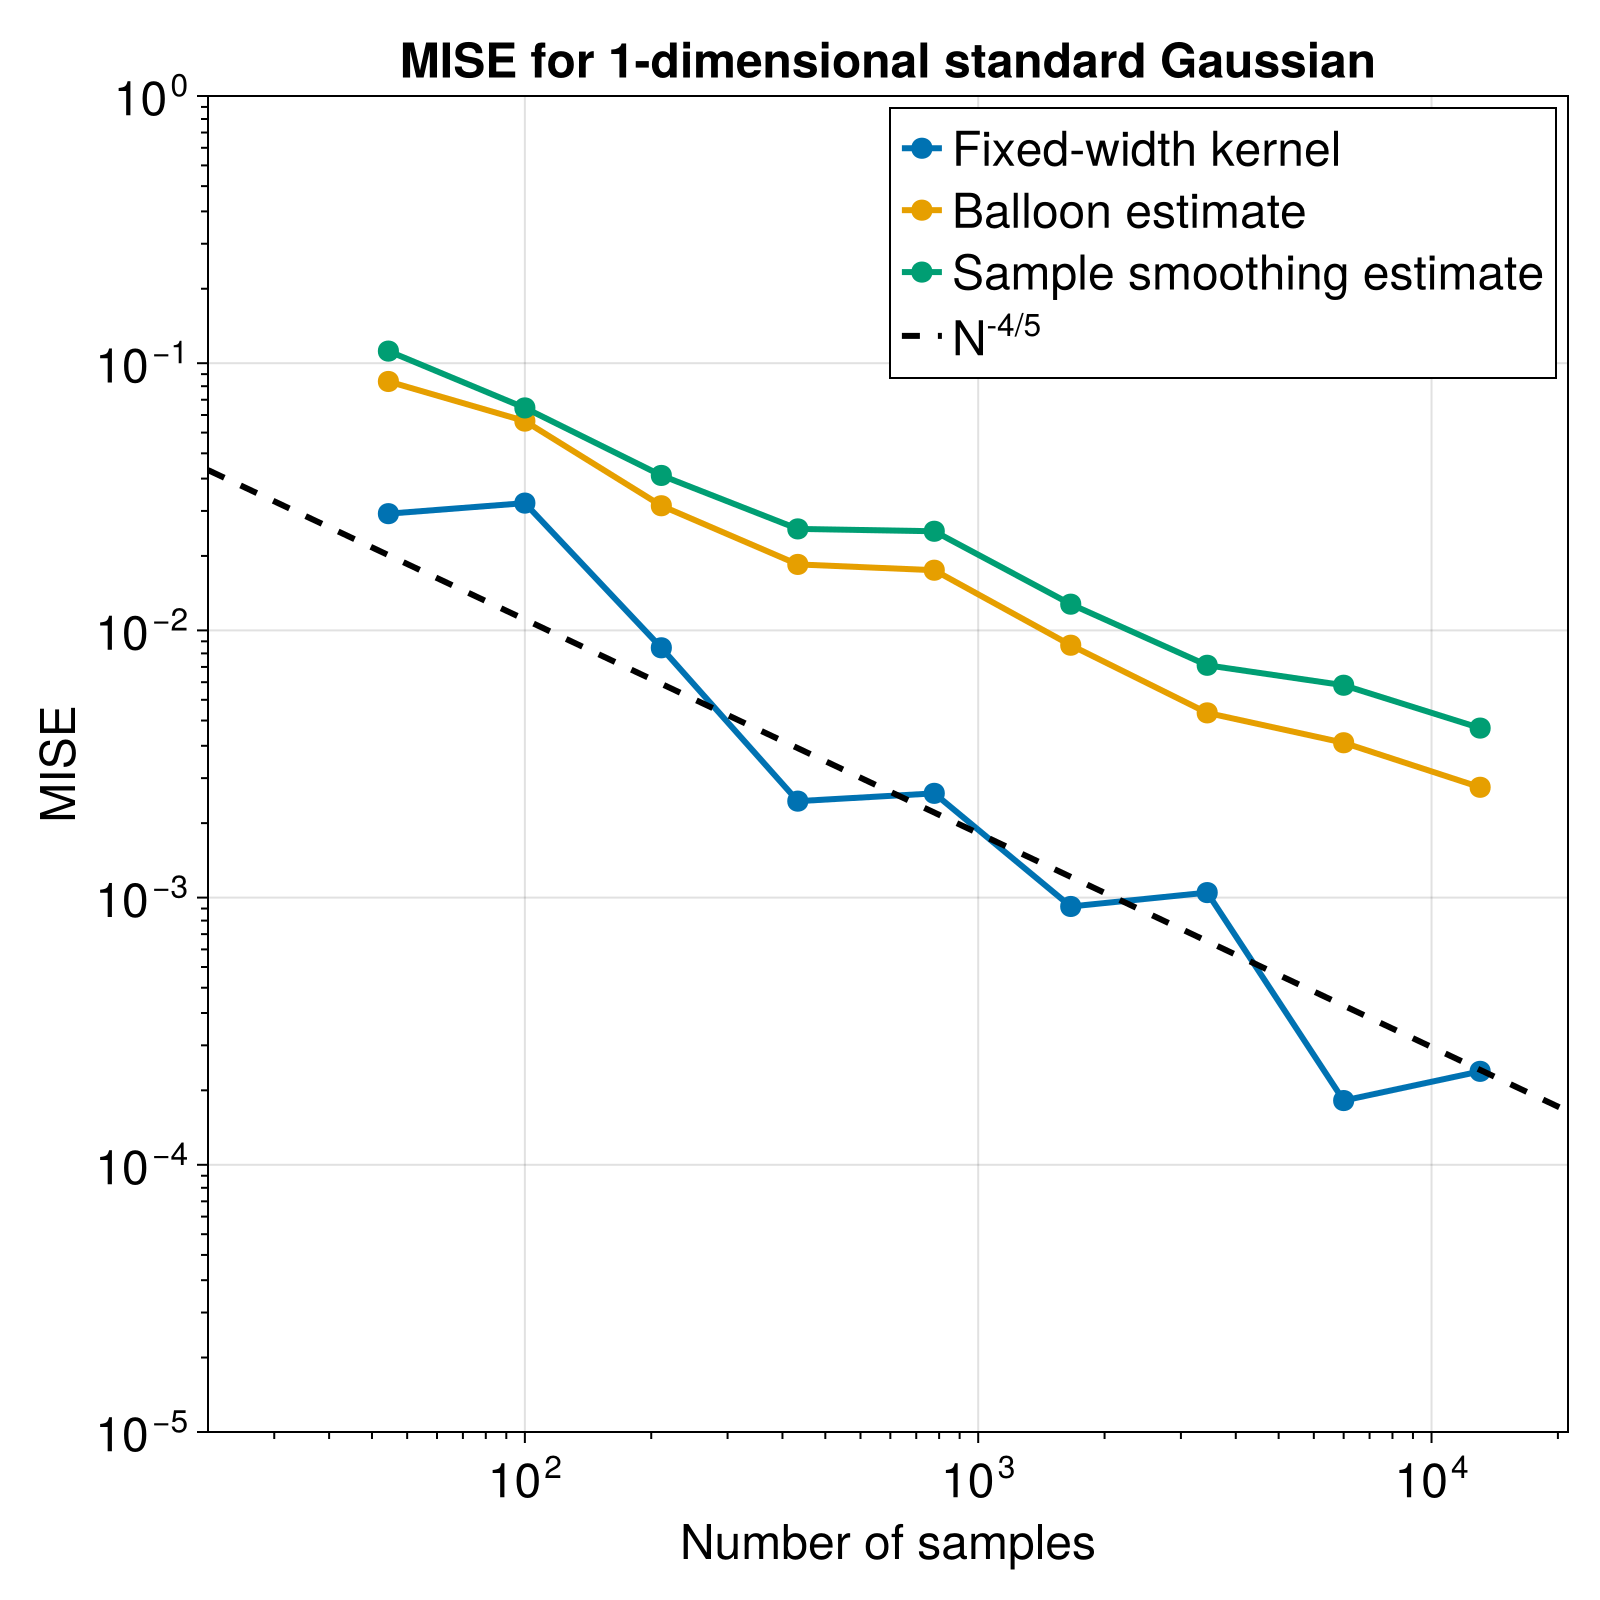

In [64]:
fig3 = Figure(size=(800, 800), fontsize=24)
ax = Axis(fig3[1, 1]; title=@sprintf("MISE for %d-dimensional standard Gaussian", d),
    xscale=log10, yscale=log10, limits=((20, 20000), (1e-5, 1)),
    xticks=LogTicks([1, 2, 3, 4]),
    xminorticks=IntervalsBetween(10), yminorticks=IntervalsBetween(10),
    xminorticksvisible=true, yminorticksvisible=true,
    ylabel="MISE", xlabel="Number of samples")

N = N0 * (2).^(0:(Ntrials-1))
scatterlines!(ax, N, fixed_width_AMISE, linewidth=3, markersize=15, label="Fixed-width kernel")
scatterlines!(ax, N, balloon_AMISE, linewidth=3, markersize=15, label="Balloon estimate")
scatterlines!(ax, N, sample_smoothing_AMISE, markersize=15, linewidth=3, label="Sample smoothing estimate")
lines!(ax, [1, 20000], 10*(N[1]*[1, 20000]).^(-4/(d+4)), color="black", linestyle=:dash, linewidth=3, label=rich("N", superscript(@sprintf("-4/%d", d+4))))

axislegend(ax, position=:rt)
save(@sprintf("images/updated_k_MISE_d=%d.png", d), fig3)
fig3

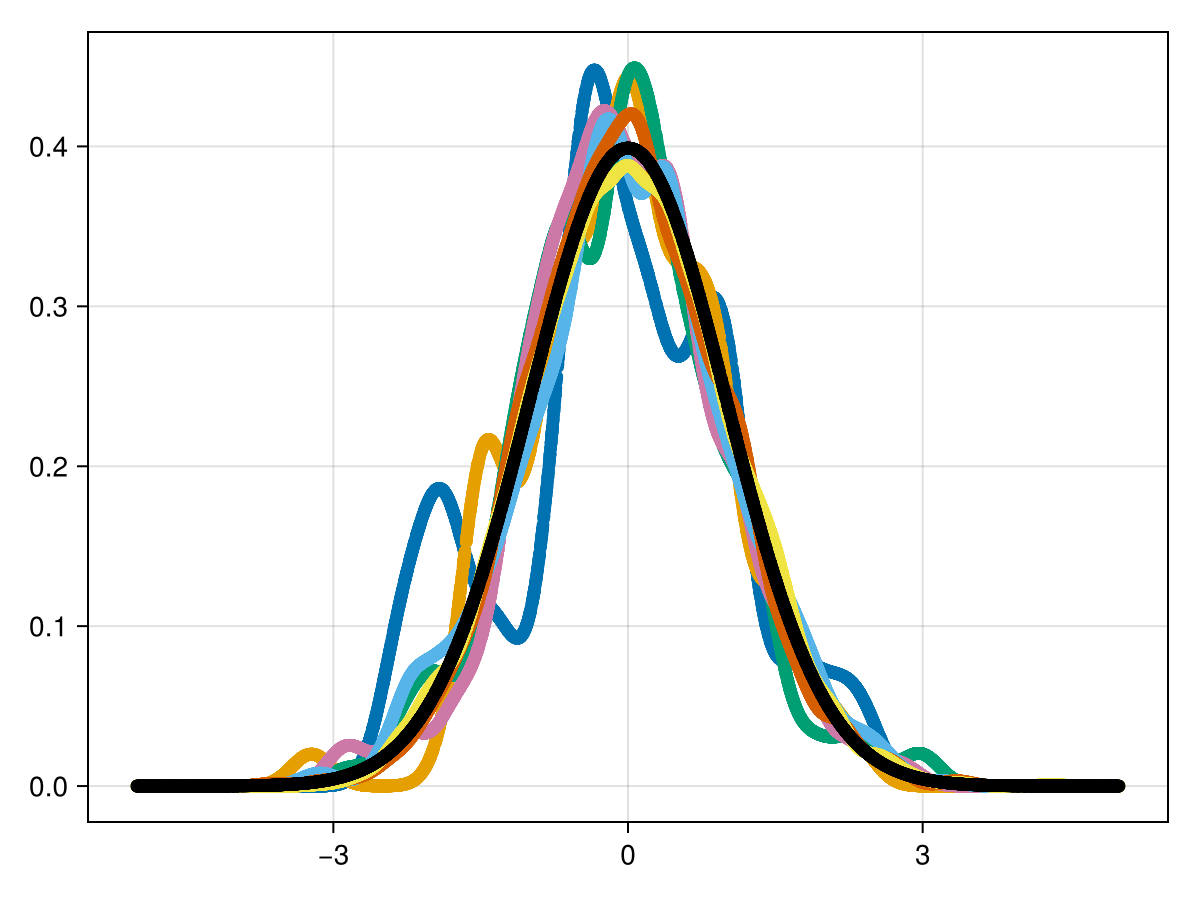

In [144]:
# Visualization for d=1
fig1 = Figure()
ax = Axis(fig1[1,1])
for i=1:Ntrials
    scatter!(ax, query_points[:], fixed_width_pdfs[i])
end

scatter!(ax, query_points[:], true_pdf.(eachrow(query_points)), color="black")

fig1

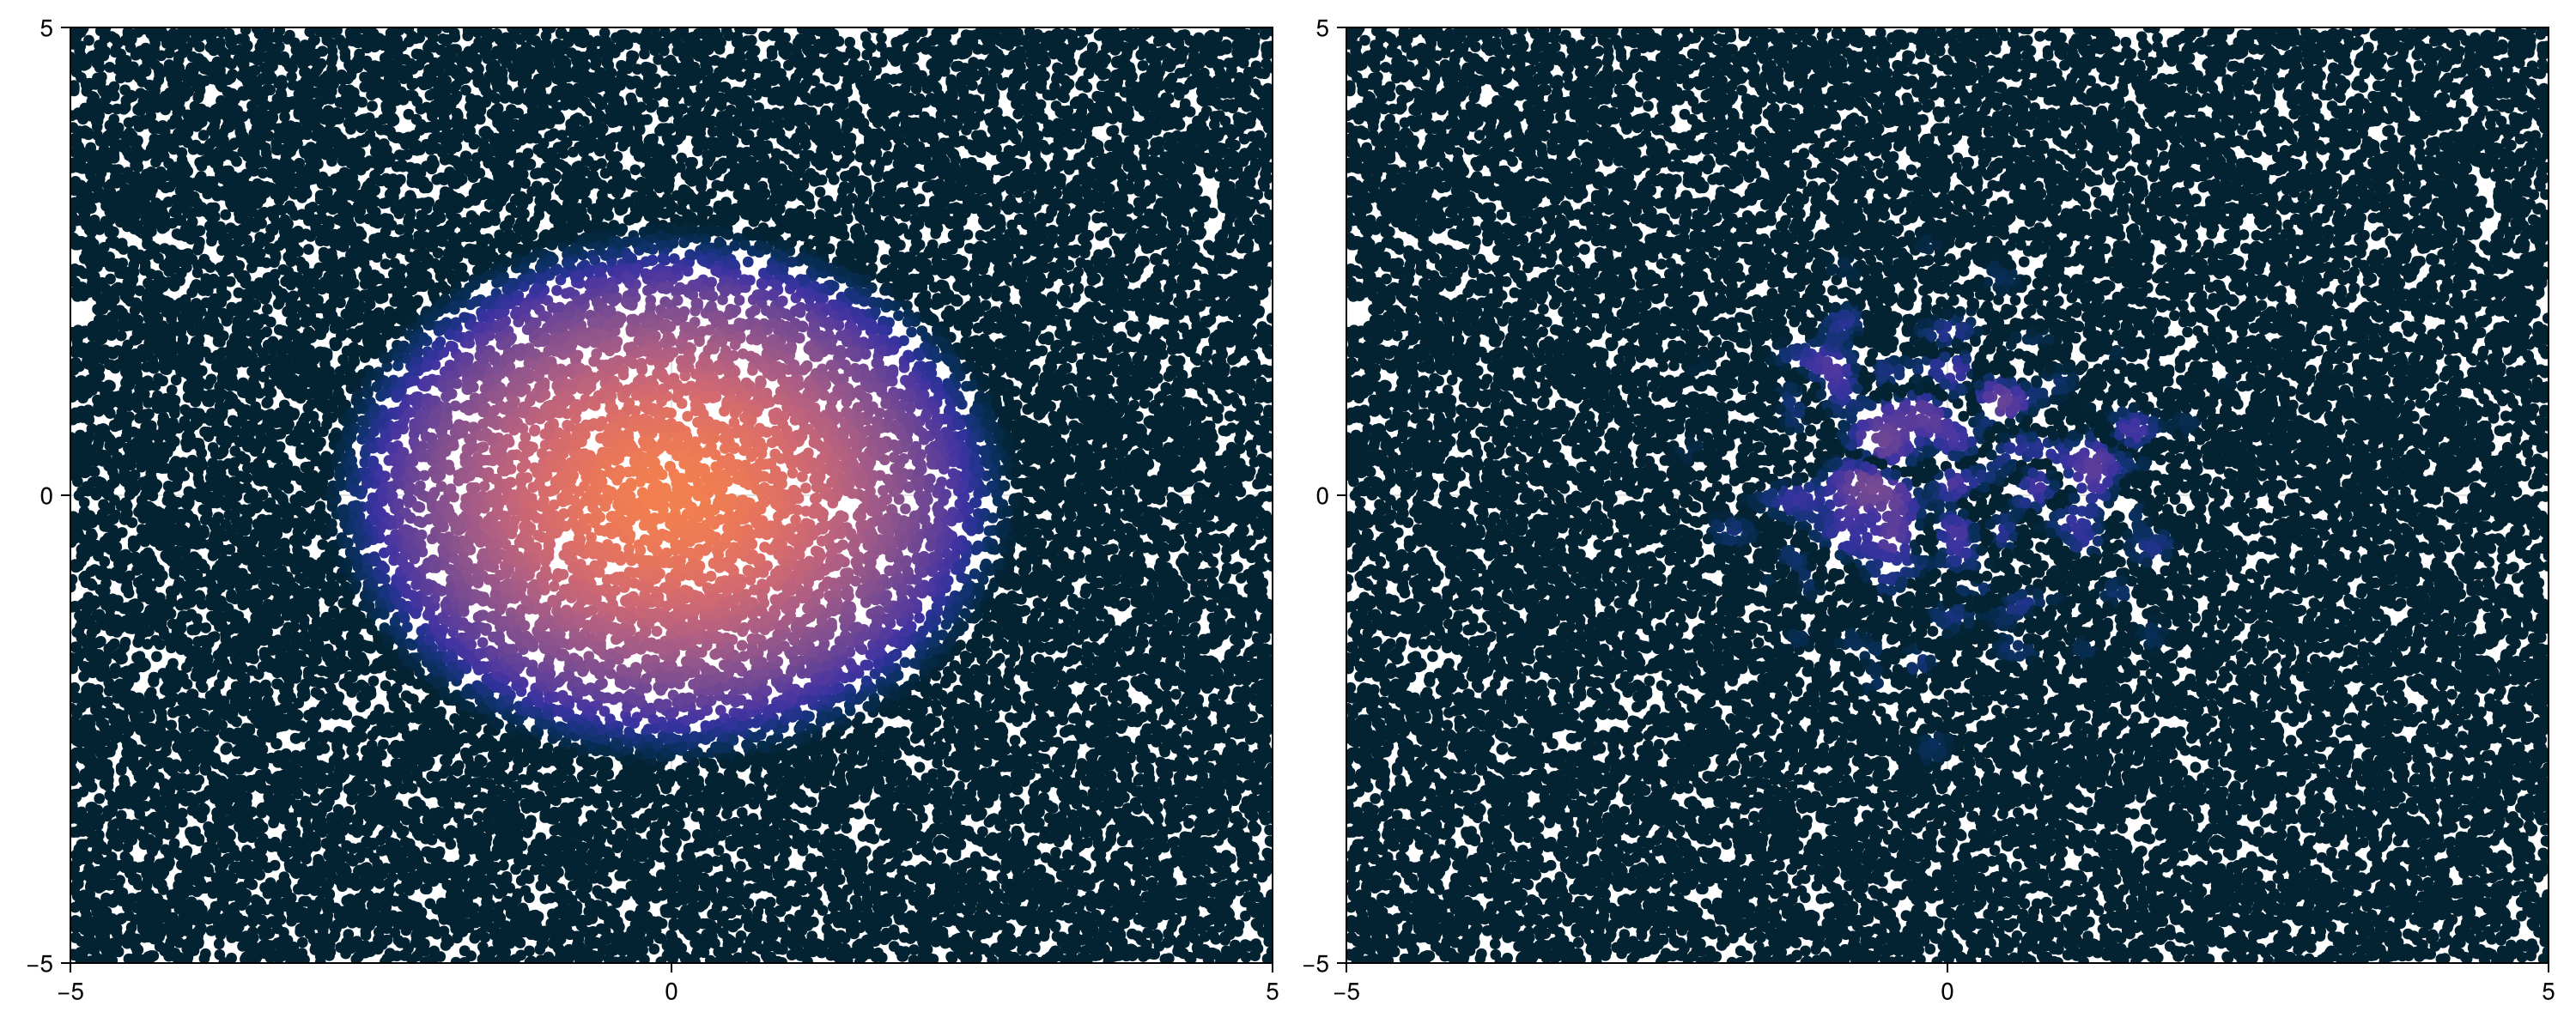

In [59]:
# Visualization for d=2
f = Figure(size=(1500, 600), fontsize=24)
ax1 = Axis(f[1,1], limits=((-5,5), (-5,5)), title=)
ax2 = Axis(f[1,2], limits=((-5,5), (-5,5)))

scatter!(ax1, query_points[:,1], query_points[:,2], colorrange=(-6,0), color=log.(abs.(fixed_width_estimate - true_pdf_values)), colormap = :thermal)
scatter!(ax2, query_points[:,1], query_points[:,2], colorrange=(-6,0), color=log.(true_pdf_values), colormap = :thermal)

#lines!(ax, query_points[1,:][:], true_values)

f